In [2]:
import pandas as pd
import numpy as np
import json
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
walmart_ml_proc = pd.read_csv('Data/walmart/wmt_ml_procs.csv')
walmart_ss_proc = pd.read_csv('Data/walmart/wmt_ss_procs.csv')
walmart_ss = pd.read_csv('Data/walmart/wmt_ss_revs.csv')
walmart_ml = pd.read_csv('Data/walmart/wmt_ml_revs.csv')
all_reviews = pd.read_pickle("Reviews_EDA/all_reviews.pkl")

In [4]:
def walmart_clean(proc, rev):
    rev['subbrand'] = ['masterlock' for x in range(len(rev))]
    rev['scrape_date'] = ['March 16, 2018' for x in range(len(rev))]
    rev['website'] = ['walmart' for x in range(len(rev))]
    temp = proc[['product_desc', 'product_rating', 'product_id', 'product_name', 'product_price']]
    temp.rename(index=str, columns={'product_desc':'description'}, inplace=True)
    rel = pd.merge(rev, temp, how='left',on='product_id')
    rel.rename(index=str, columns={'product_id':'model'}, inplace=True)
    rel.drop('Unnamed: 0', inplace=True,axis=1)
    return rel

In [5]:
wmt_ss = walmart_clean(walmart_ss_proc, walmart_ss)
wmt_ml = walmart_clean(walmart_ml_proc, walmart_ml)
all_reviews = pd.concat([all_reviews,wmt_ss, wmt_ml], ignore_index=True)
# all_reviews

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [6]:
with open('Data/amazon_results_3.json', 'r') as file:
    amazon_rev  = json.load(file)

In [7]:
def amazon_clean(amazon):
    list_df = [pd.DataFrame(x,index=range(len(x))) for x in amazon_rev]
    amazon = pd.concat(list_df, ignore_index=True)
    amazon.drop('error', inplace=True, axis=1)
    amazon.columns = ['review_date','product_name','product_price','review_rating','review_content','review_title']
    amazon['scrape_date'] = ['March 16, 2018' for x in range(len(amazon))]
    amazon['website'] = ['amazon' for x in range(len(amazon))]
    amazon.loc[:,'review_date'] = amazon.loc[:,'review_date'].str.replace('on ', '')
    amazon.loc[:,'review_rating'] = [float(x.split(' out ')[0]) if x is not np.nan else np.nan for x in amazon['review_rating']]
    amazon.dropna(axis=0, how='any', inplace=True)
    return amazon

In [8]:
amazon = amazon_clean(amazon_rev)

In [9]:
amazon["product_name"].iloc[100]

'Steel Padlock With Keys (HEAVY DUTY SECURITY) 100% Waterproof - Safely Lock Interior or Exterior Gates, Sheds, Lockers, Bikes, Tool Box, or Containers. Includes 3 Master Keys'

In [10]:
all_reviews_am = pd.concat([all_reviews, amazon], ignore_index=True)
all_reviews_am.drop(['description','model','product_rating','reviewer','subbrand'], axis=1, inplace=True)

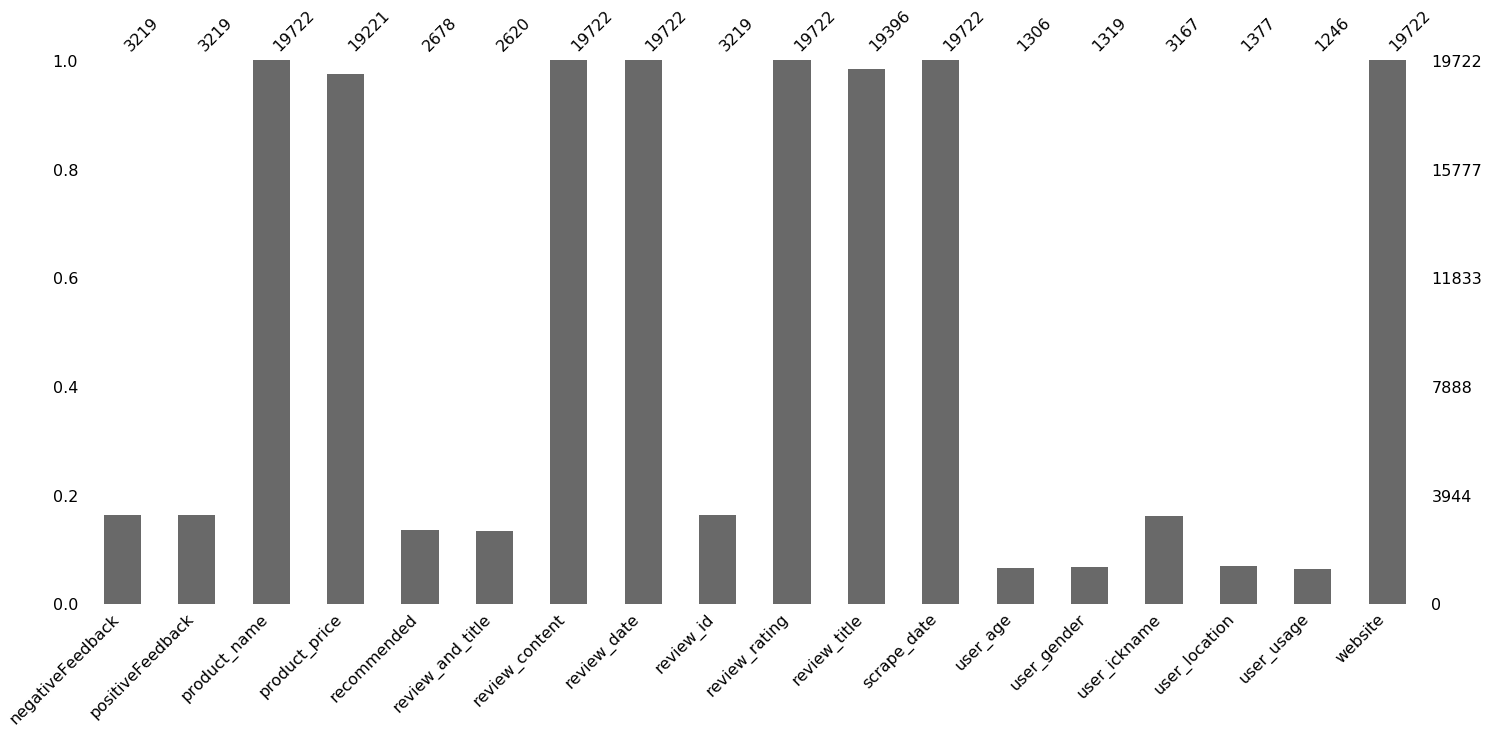

In [11]:
msno.bar(all_reviews_am)

In [168]:
all_reviews.to_pickle("all_reviews_wmt.pkl")
all_reviews_am.to_pickle("all_reviews_wmt_amaz.pkl")

In [14]:
df = pd.read_pickle("Reviews_EDA/all_reviews_wmt_amaz.pkl")

In [15]:
zoro = pd.read_csv("Data/zoro/zoro_reviews.csv")
zoro['website'] = "zoro"
zoro["review_rating"] = zoro["review_rating"].round(0)

In [16]:
len(df), len(zoro)

(19722, 302)

In [17]:
df = pd.concat([df, zoro])

In [18]:
len(df)

20024

In [19]:
df['product_price'] = df['product_price'].astype(str).str.replace("$", " ")
df = df[df['product_price'].notnull()]
df['product_price'] = df['product_price'].str.split(' -').str[0]
df["product_price"] = df['product_price'].astype(float)

In [20]:
set(df['website'].values)

{'amazon', 'costco', 'homedepot', 'lowes', 'walmart', 'zoro'}

In [21]:
max(list(df.groupby("review_rating").mean()['product_price']))#.apply(list)

55.01962682379342

In [22]:
[str(x) for x in list(df.groupby("review_rating").mean().index.values)]

['1.0', '2.0', '3.0', '4.0', '5.0']

In [289]:
df.drop("price_range", axis=1, inplace=True)

In [23]:
df["price_range"] = pd.cut(df["product_price"], bins=[0, 10, 20, 50, 100, 500, 1000, 2000], labels=["$0-10", "$10-20", "$20-50","$50-100","$100-500","$500-1000","$1000+"])

In [24]:
other_brand_aliases = [
    "AdirOffice",
    "AmazonBasics",
    "Bushnell",
    "T-Lock",
    "ABUS",
    "Lion Locks",
    "Puroma",
    "Adoric",
    "ORIA",
    "WHOSEE"
]

df.loc[df['product_name'].str.contains('|'.join(other_brand_aliases)), 'subbrand'] = 'other'


sentry_aliases = [
    "Sentry",
    "Fire and Water Combination Dial Safe",
    "Electronic Lock Fire Safe",
    "Fire Resistant Security Safe with Electronic Lock",
    "Fire Resistant Electronic Lock",
    "safe", "Safe",
    "Locking Cash Box With Money Tray"

]

df.loc[df['product_name'].str.contains('|'.join(sentry_aliases)), 'subbrand'] = 'sentry'
masterlock_aliases = [
    "MASTER LOCK",
    "MASTERLOCK",
    'Master',
    "Fortress",
    'TSA',
    'Magnum',
    "Set-Your-Own",
    "Solid Body Padlock",
    "Select Access Portable Key Storage",
    "Steel Fire-Resistant Waterproof Combination Dial Lock",
    
]
df.loc[df['product_name'].str.contains('|'.join(masterlock_aliases)), 'subbrand'] = 'masterlock'